In [1]:
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
from keras.models import Sequential, Model
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import string
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import random
from gtts import gTTS
import IPython.display as ipd
import time
from PIL import Image

2024-04-29 18:26:10.543135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 18:26:18.648510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
path_train = 'sign_mnist_train.csv'
path_test = 'sign_mnist_test.csv'


train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

In [7]:
def parse_data(filename):
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        labels = []
        images = []
        next(csv_reader, None)

        for row in csv_reader:
            label = row[0]
            image = row[1:]
            image = np.array(image).reshape((28, 28))

            labels.append(label)
            images.append(image)

        images = np.array(images).astype(float)
        labels_normal = np.array(labels).astype(float)
        labels = to_categorical(labels, num_classes=25)
    return images, labels, labels_normal

In [8]:
training_images, training_labels, training_labels_normal = parse_data(path_train)
validation_images, validation_labels, validation_labels_normal = parse_data(path_test)

In [9]:
training_images.shape

(27455, 28, 28)

In [10]:
labels = np.unique(training_labels_normal)
print(labels)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]


In [12]:
training_labels.shape

(27455, 25)

In [11]:
number_to_alphabet = {
            0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
            18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
        }

In [14]:
validation_normalized = ((validation_images - validation_images.min()) / (validation_images.max() - validation_images.min())*255).astype(np.uint8)

22.0 : W


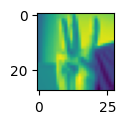

In [15]:
plt.figure(figsize=(1,1))
plt.imshow(training_images[200].reshape(28,28))
print(training_labels_normal[200],":",number_to_alphabet[training_labels_normal[200]])

In [16]:
training_images = np.expand_dims(training_images, axis=3)
validation_images = np.expand_dims(validation_images, axis=3)

In [17]:
def img_generator(training_images, training_labels, validation_images, validation_labels):

    train_datagen = ImageDataGenerator(
                        rescale = 1./255,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')

    train_generator = train_datagen.flow(x=training_images, y=training_labels, batch_size=32)

    valid_datagen = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_datagen.flow(x=validation_images, y=validation_labels, batch_size=32)

    return train_generator, valid_generator

In [18]:
train_generator, validation_generator = img_generator(training_images, training_labels,
                                                      validation_images, validation_labels)

print(f"Training generator images have shape : {train_generator.x.shape}")
print(f"Training generator labels have shape : {train_generator.y.shape}")
print(f"Validation generator images have shape : {validation_generator.x.shape}")
print(f"Validation generator labels have shape : {validation_generator.y.shape}")

Training generator images have shape : (27455, 28, 28, 1)
Training generator labels have shape : (27455, 25)
Validation generator images have shape : (7172, 28, 28, 1)
Validation generator labels have shape : (7172, 25)


In [24]:
def model():

    model = Sequential()
    model.add(Conv2D(75, kernel_size=(3,3), padding = 'same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides = 2 , padding = 'same'))
    
    model.add(Conv2D(50, kernel_size=(3,3), padding = 'same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(25 , (3,3) , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Flatten())
    # fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    # output layer
    model.add(Dense(25, activation='softmax'))
    model.summary()
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=((28, 28, 1))),
    #     tf.keras.layers.MaxPool2D(2,2),
    #     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    #     tf.keras.layers.MaxPool2D(2,2),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dense(26, activation='softmax')
    # ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [25]:
cnn_model = model()

/home/students/baggarwa/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,562 (1.01 MB)

 Trainable params: 264,262 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [26]:
cnn_history = cnn_model.fit(train_generator, epochs = 50, validation_data = validation_generator)
#history = model.fit(training_images, training_labels_normal,validation_data = (validation_images, validation_labels_normal), epochs = 70)

Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.2075 - loss: 2.6736 - val_accuracy: 0.4368 - val_loss: 1.5502
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5719 - loss: 1.2813 - val_accuracy: 0.7712 - val_loss: 0.6660
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.6956 - loss: 0.8848 - val_accuracy: 0.6870 - val_loss: 0.9468
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7548 - loss: 0.7178 - val_accuracy: 0.7195 - val_loss: 0.7372
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7911 - loss: 0.5997 - val_accuracy: 0.7798 - val_loss: 0.6564
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8194 - loss: 0.5265 - val_accuracy: 0.8100 - val_loss: 0.5065
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8431 - loss: 0.4640 - val_accuracy: 0.6972 - val_loss: 1.2299
Epoch 8/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8416 - loss: 0.4533 - 

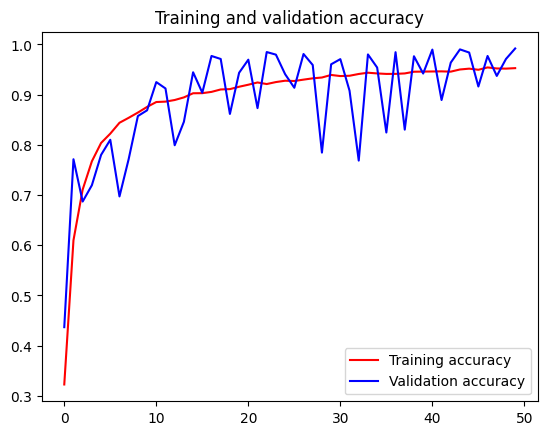

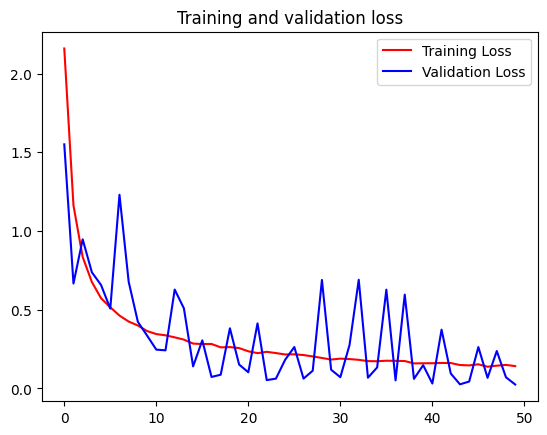

In [27]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(len(acc))

plt.title('Accuracy and Loss for CNN Model')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
(1, 25)
0 2.2798492e-09
1 1.0743424e-11
2 3.6177558e-16
3 3.133839e-13
4 1.0
5 3.2442484e-15
6 9.846058e-30
7 1.0789795e-22
8 4.9581666e-15
9 1.9644755e-28
10 3.0576512e-19
11 7.0756364e-30
12 5.364029e-09
13 2.274768e-12
14 3.5556946e-12
15 9.442651e-20
16 2.119628e-21
17 5.3428264e-22
18 4.7122418e-14
19 8.649194e-24
20 4.2354834e-21
21 3.363603e-30
22 4.5236617e-25
23 4.1395672e-19
24 1.6328497e-21
--------------
Predicted label 4 : E
Actual Label 4 : E


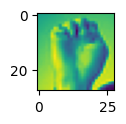

In [28]:
image_index = 567
plt.figure(figsize=(1,1))
normalized_image = validation_images[image_index] / 255.0
plt.imshow(normalized_image.reshape(28, 28))
pred = cnn_model.predict(normalized_image.reshape(1, 28, 28, 1))
print(pred.shape)
for i in range(pred.shape[1]):
    print (i,pred[0,i])
#print(pred)
print('--------------')
print("Predicted label",pred.argmax(),":",number_to_alphabet[pred.argmax()])
print("Actual Label", int(validation_labels_normal[image_index]),":",number_to_alphabet[validation_labels_normal[image_index]])

In [33]:
train_predict = cnn_model.predict(train_generator.x)
validation_predict = cnn_model.predict(validation_generator.x)

# Calculate train data RMSE
print("Root mean Squared Error(Training Data) : ", math.sqrt(mean_squared_error(train_generator.y,train_predict)))
print("Mean Absolute Error(Training Data) : ", mean_absolute_error(train_generator.y,train_predict))
# Calculate validation data RMSE
print("Root mean Squared Error(validation Data) : ",math.sqrt(mean_squared_error(validation_generator.y,validation_predict)))
print("Mean Absolute Error(Validation Data) : ",mean_absolute_error(validation_generator.y,validation_predict))

858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Root mean Squared Error(Training Data) :  0.23384266402142706
Mean Absolute Error(Training Data) :  0.05473574548163412
Root mean Squared Error(validation Data) :  0.23591683914176456
Mean Absolute Error(Validation Data) :  0.05571298685830299


In [35]:
# serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # # serialize weights to HDF5
# model.save_weights("model.weights.h5")

cnn_model.save('cnn_model.h5')

RNN model Training 

In [36]:
def rnn_model():

    model = Sequential()
    model.add(Reshape((28, 28*1), input_shape=(28, 28, 1)))
    # LSTM layers
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.4))

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(25, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    return model

In [37]:
rnn_model = rnn_model()

/home/students/baggarwa/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,857 (597.10 KB)

 Trainable params: 152,857 (597.10 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
rnn_history = rnn_model.fit(train_generator, epochs = 70, validation_data = validation_generator)

Epoch 1/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.0559 - loss: 3.1763 - val_accuracy: 0.0986 - val_loss: 2.9743
Epoch 2/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.1036 - loss: 2.9807 - val_accuracy: 0.1790 - val_loss: 2.5471
Epoch 3/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.1523 - loss: 2.7240 - val_accuracy: 0.2999 - val_loss: 2.1607
Epoch 4/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.2097 - loss: 2.4860 - val_accuracy: 0.3496 - val_loss: 1.9516
Epoch 5/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.2502 - loss: 2.3314 - val_accuracy: 0.3724 - val_loss: 1.7707
Epoch 6/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.2843 - loss: 2.2039 - val_accuracy: 0.4322 - val_loss: 1.6283
Epoch 7/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.3196 - loss: 2.0998 - val_accuracy: 0.4566 - val_loss: 1.5248
Epoch 8/70
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.3424 - loss: 1.9913 - 

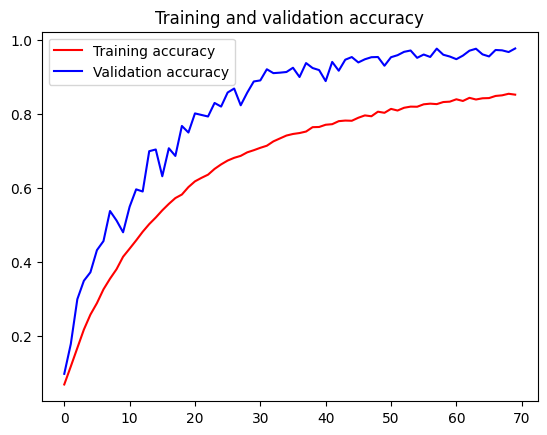

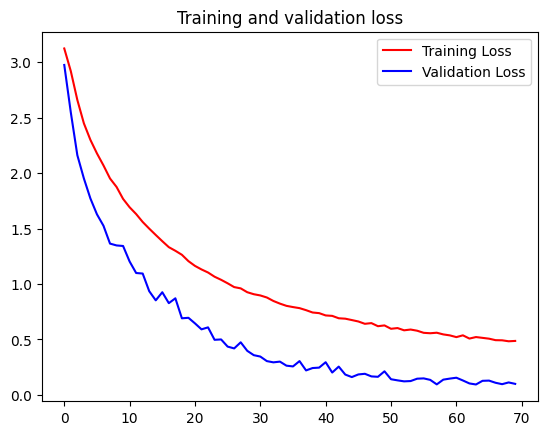

In [40]:
acc = rnn_history.history['accuracy']
val_acc = rnn_history.history['val_accuracy']
loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 25)
0 2.2711782e-10
1 1.5999375e-10
2 4.4366425e-07
3 1.8207693e-06
4 2.088056e-08
5 0.00021292616
6 0.99361455
7 0.0031082942
8 3.662353e-08
9 2.606714e-23
10 9.888839e-09
11 2.5179966e-06
12 2.6218176e-08
13 2.729822e-09
14 4.407943e-07
15 4.0737234e-07
16 1.6060849e-06
17 8.2467096e-08
18 6.039567e-09
19 0.0029002328
20 4.3391798e-10
21 6.1414434e-09
22 4.84503e-09
23 0.00015635806
24 1.4960487e-07
--------------
Predicted label 6 : G
Actual Label 6 : G


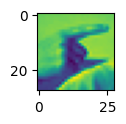

In [47]:
image_index = 0
normalized_image = validation_images[image_index]/ 255.0
plt.figure(figsize=(1,1))
plt.imshow(normalized_image.reshape(28, 28))#,cmap='Greys')
pred = rnn_model.predict(normalized_image.reshape(1, 28, 28))
print(pred.shape)
for i in range(pred.shape[1]):
    print (i,pred[0,i])

#print(pred)
print('--------------')
print("Predicted label",pred.argmax(),":",number_to_alphabet[pred.argmax()])
print("Actual Label", int(validation_labels_normal[image_index]),":",number_to_alphabet[validation_labels_normal[image_index]])

In [54]:
train_predict = rnn_model.predict(train_generator.x.reshape(train_generator.x.shape[0], 28, 28))
validation_predict = rnn_model.predict(validation_generator.x.reshape(validation_generator.x.shape[0], 28, 28))

# Calculate train data RMSE
print("Root mean Squared Error(Training Data) : ", math.sqrt(mean_squared_error(train_generator.y,train_predict)))
print("Mean Absolute Error(Training Data) : ", mean_absolute_error(train_generator.y,train_predict))
# Calculate validation data RMSE
print("Root mean Squared Error(validation Data) : ",math.sqrt(mean_squared_error(validation_generator.y,validation_predict)))
print("Mean Absolute Error(Validation Data) : ",mean_absolute_error(validation_generator.y,validation_predict))

858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Root mean Squared Error(Training Data) :  0.2564751127301596
Mean Absolute Error(Training Data) :  0.07630892649425944
Root mean Squared Error(validation Data) :  0.25575447229891757
Mean Absolute Error(Validation Data) :  0.07572513167019695


In [55]:
# serialize model to JSON
# rnn_model_json = rnn_model.to_json()
# with open("/content/drive/MyDrive/H518-DeepLearning/Project/Attempt1/rnn_model.json", "w") as json_file:
#     json_file.write(rnn_model_json)
# # serialize weights to HDF5
# rnn_model.save_weights("/content/drive/MyDrive/H518-DeepLearning/Project/Attempt1/rnn_model.weights.h5")

rnn_model.save('rnn_model.h5')

Transfer Learning with Mobilenet

In [2]:
# Function to parse and resize data from CSV file
def parse_data(filename):
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        labels = []
        images = []
        next(csv_reader, None)  # skip the header
        for row in csv_reader:
            label = row[0]
            image = np.array(row[1:]).reshape((28, 28)).astype(np.float32)
            image = Image.fromarray(image)  # Convert array to PIL Image to resize
            image = image.resize((224, 224))  # Resize image to 224x224
            image = np.stack([image]*3, axis=-1)  # Convert to 3 channel
            images.append(image)
            labels.append(int(label))
            
        images = np.array(images)
        labels_normal = np.array(labels).astype(float)
        labels = to_categorical(labels, num_classes=26)
    return images, labels, labels_normal

# Load and prepare training and validation datasets
training_images, training_labels, training_labels_normal = parse_data("sign_mnist_train.csv")
validation_images, validation_labels, validation_labels_normal = parse_data("sign_mnist_test.csv")

# Data augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x=training_images, y=training_labels, batch_size=32)

valid_generator = validation_datagen.flow(x=validation_images, y=validation_labels, batch_size=32)

In [3]:
# Using MobileNet
def mobileNet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(26, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers except the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [4]:
# Instantiate and train the model
mobilenet_model = mobileNet_model()


2024-04-29 18:28:03.761648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-04-29 18:28:03.763113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9803 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-04-29 18:28:03.764361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9803 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:87:00.0, compute capability: 7.5
2024-04-29 18:28:03.765582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 7505 MB memory:  -> device: 3, name: NVIDIA GeForce GTX

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,255,514 (12.42 MB)

 Trainable params: 1,077,274 (4.11 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

In [12]:
# Fitting the model
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


Epoch 1/10


/home/students/baggarwa/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714418877.831536  830157 service.cc:145] XLA service 0x7efea8005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714418877.832029  830157 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1714418877.832039  830157 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1714418877.832044  830157 service.cc:153]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1714418877.832048  830157

  1/858 ━━━━━━━━━━━━━━━━━━━━ 3:12:00 13s/step - accuracy: 0.0312 - loss: 4.4164

I0000 00:00:1714418883.354858  830157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


858/858 ━━━━━━━━━━━━━━━━━━━━ 429s 485ms/step - accuracy: 0.8515 - loss: 0.5070 - val_accuracy: 0.8302 - val_loss: 0.5383
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 414s 479ms/step - accuracy: 0.9777 - loss: 0.0720 - val_accuracy: 0.8852 - val_loss: 0.3448
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 413s 477ms/step - accuracy: 0.9837 - loss: 0.0503 - val_accuracy: 0.8169 - val_loss: 0.9029
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 413s 478ms/step - accuracy: 0.9864 - loss: 0.0388 - val_accuracy: 0.8235 - val_loss: 0.7894
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 412s 476ms/step - accuracy: 0.9869 - loss: 0.0407 - val_accuracy: 0.9297 - val_loss: 0.2292
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 416s 481ms/step - accuracy: 0.9910 - loss: 0.0294 - val_accuracy: 0.6804 - val_loss: 1.8508
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 415s 479ms/step - accuracy: 0.9896 - loss: 0.0311 - val_accuracy: 0.9695 - val_loss: 0.0826
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 414s 479ms/step - accuracy: 0.9899 - loss: 0.03

In [13]:
mobilenet_model.save('mobilenet_model.h5')

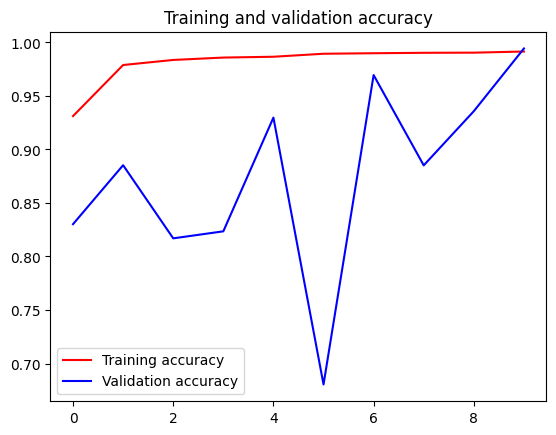

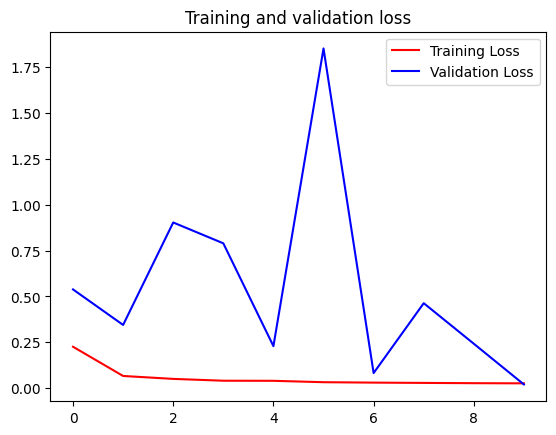

In [14]:
acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 26)
0 6.611985e-16
1 5.0437685e-11
2 8.972777e-12
3 7.6535804e-07
4 2.7116857e-12
5 2.6959414e-08
6 6.6048724e-17
7 5.2432856e-20
8 0.9999989
9 5.676255e-17
10 1.5369758e-10
11 5.1103063e-14
12 8.725283e-14
13 7.3627617e-13
14 2.7478972e-16
15 1.0431621e-18
16 3.4712167e-16
17 2.7414483e-08
18 3.3170068e-12
19 1.1438079e-17
20 1.2190117e-12
21 1.21404495e-14
22 3.577418e-16
23 2.706237e-14
24 2.1543163e-07
25 1.1112939e-15
--------------
Predicted label 8 : I
Actual Label 8 : I


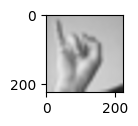

In [16]:
number_to_alphabet = {
            0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
            18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
        }
image_index = 3000
normalized_image = validation_images[image_index] / 255.0
plt.figure(figsize=(1,1))
plt.imshow(normalized_image.reshape(224,224,3))
pred = mobilenet_model.predict(normalized_image.reshape(1, 224, 224, 3))
print(pred.shape)
for i in range(pred.shape[1]):
    print (i,pred[0,i])
#print(pred)
print('--------------')
print("Predicted label",pred.argmax(),":",number_to_alphabet[pred.argmax()])
print("Actual Label", int(validation_labels_normal[image_index]),":",number_to_alphabet[validation_labels_normal[image_index]])

In [6]:
# print("Starting prediction of traing data")
# train_predict = mobilenet_model.predict(train_generator.x)

print("Starting prediction of validation data")
validation_predict = mobilenet_model.predict(valid_generator.x)


Starting prediction of validation data
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [7]:
# # Calculate train data RMSE
# print("Root mean Squared Error(Training Data) : ", math.sqrt(mean_squared_error(train_generator.y,train_predict)))
# print("Mean Absolute Error(Training Data) : ", mean_absolute_error(train_generator.y,train_predict))

# Calculate validation data RMSE and Mean Absolute Data
print("Root mean Squared Error(validation Data) : ",math.sqrt(mean_squared_error(valid_generator.y,validation_predict)))
print("Mean Absolute Error(Validation Data) : ",mean_absolute_error(valid_generator.y,validation_predict))

Root mean Squared Error(validation Data) :  0.25449874183830334
Mean Absolute Error(Validation Data) :  0.07320899020634714


In [8]:
#get the predicted labels for the validation set
y_pred = mobilenet_model.predict(valid_generator.x)
y_pred_labels = np.argmax(y_pred, axis=1)


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


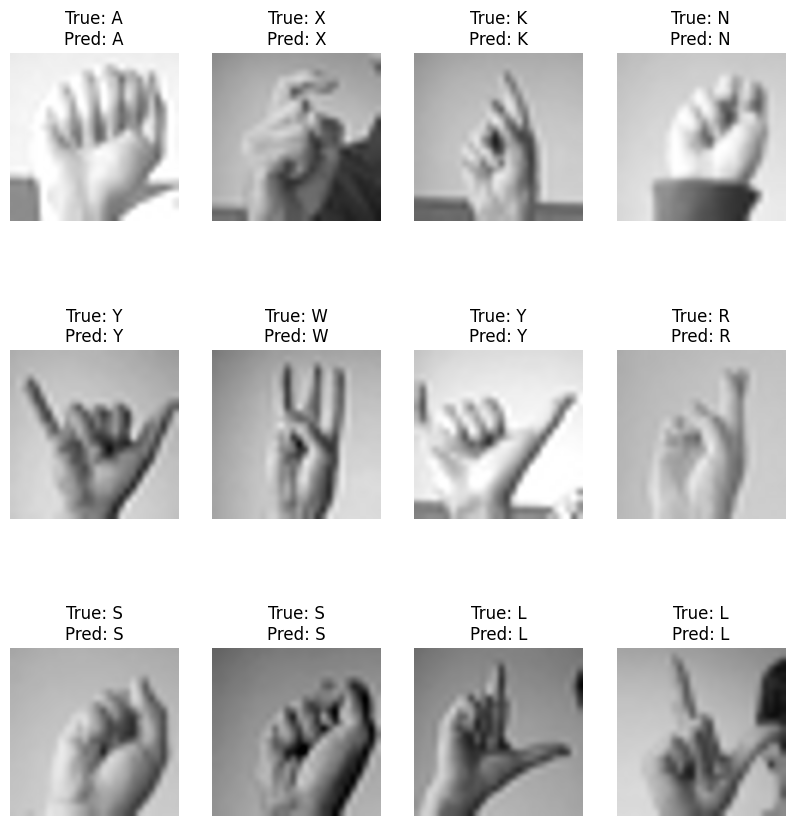

In [13]:
# display random predictions
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.7, wspace= 0.2)
for i, ax in enumerate(axs.flat):
    idx = random.randint(0, len(valid_generator.x)-1) 
    ax.imshow(valid_generator.x[idx] / 255.0)
    ax.set_title(f"True: {number_to_alphabet[validation_labels_normal[idx]]}\nPred: {number_to_alphabet[validation_labels_normal[idx]]}")
    ax.axis('off')
plt.show()